<a href="https://colab.research.google.com/github/Oshi16/DeepSC/blob/master/VAE_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import binary_crossentropy
import matplotlib.pyplot as plt

# For adding noise and channel effects
def rayleigh_fading_channel(x, snr_db):
    # Simulate Rayleigh fading
    # Generate complex Gaussian random variables for Rayleigh fading
    noise_real = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=1.0, dtype=x.dtype)
    noise_imag = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=1.0, dtype=x.dtype)
    fading = tf.sqrt(tf.square(noise_real) + tf.square(noise_imag))

    # Scale the fading factor to the latent space
    #fading = tf.expand_dims(fading, axis=-1)  # Expand dimensions if necessary to match x

    faded_x = x * fading

    # Calculate signal power and convert SNR from dB to linear scale
    signal_power = tf.reduce_mean(tf.square(faded_x))
    snr_linear = 10 ** (snr_db / 10.0)

    # Calculate noise power based on SNR
    noise_power = signal_power / snr_linear

    # Add AWGN noise
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=tf.sqrt(noise_power), dtype=x.dtype)
    noisy_x = faded_x + noise

    return noisy_x

def rician_fading_channel(x, snr_db, K):
    # Simulate Rician fading
    # Generate complex Gaussian random variables for the scattering component
    noise_real = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=1.0, dtype=x.dtype)
    noise_imag = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=1.0, dtype=x.dtype)
    scattering = tf.sqrt(tf.square(noise_real) + tf.square(noise_imag))

    # Calculate the line-of-sight component
    los_component = tf.sqrt(K / (K + 1))  # Line-of-sight (LOS) factor
    scattering_component = scattering / tf.sqrt(K + 1)  # Scattering component

    # Combine LOS and scattering components
    fading = los_component + scattering_component

    # Apply fading to the signal
    faded_x = x * fading

    # Calculate signal power and convert SNR from dB to linear scale
    signal_power = tf.reduce_mean(tf.square(faded_x))
    snr_linear = 10 ** (snr_db / 10.0)

    # Calculate noise power based on SNR
    noise_power = signal_power / snr_linear

    # Add AWGN noise
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=tf.sqrt(noise_power), dtype=x.dtype)
    noisy_x = faded_x + noise

    return noisy_x

def nakagami_fading_channel(x, snr_db, m):
    # Simulate Nakagami-m fading
    # Generate gamma distributed random variables for Nakagami-m fading
    fading = tf.random.gamma(shape=tf.shape(x), alpha=m, beta=1.0/m, dtype=x.dtype)

    # Apply fading to the signal
    faded_x = x * fading

    # Calculate signal power and convert SNR from dB to linear scale
    signal_power = tf.reduce_mean(tf.square(faded_x))
    snr_linear = 10 ** (snr_db / 10.0)

    # Calculate noise power based on SNR
    noise_power = signal_power / snr_linear

    # Add AWGN noise
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=tf.sqrt(noise_power), dtype=x.dtype)
    noisy_x = faded_x + noise

    return noisy_x

In [ ]:
# Load the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize and reshape the data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
def build_encoder(latent_dim):
    encoder_inputs = layers.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    return models.Model(encoder_inputs, [z_mean, z_log_var], name='encoder')

In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
def build_decoder(latent_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)  # Corrected reshape dimensions
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
    return models.Model(latent_inputs, decoder_outputs, name='decoder')

In [ ]:
'''
import tensorflow as tf

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, snr_db, K, m):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.snr_db = snr_db
        self.K = K  # Rician factor
        self.m = m  # Nakagami-m parameter

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = Sampling()([z_mean, z_log_var])

        # Pass through Rayleigh fading channel with AWGN noise
        z_noisy_rayleigh = rayleigh_fading_channel(z, self.snr_db)
        reconstructed_rayleigh = self.decoder(z_noisy_rayleigh)

        # Pass through Rician fading channel with AWGN noise
        z_noisy_rician = rician_fading_channel(z, self.snr_db, self.K)
        reconstructed_rician = self.decoder(z_noisy_rician)

        # Pass through Nakagami-m fading channel with AWGN noise
        z_noisy_nakagami = nakagami_fading_channel(z, self.snr_db, self.m)
        reconstructed_nakagami = self.decoder(z_noisy_nakagami)

        # Compute the KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)

        return reconstructed_rayleigh, reconstructed_rician, reconstructed_nakagami
'''

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, snr_db):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.snr_db = snr_db

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = Sampling()([z_mean, z_log_var])

        # Pass through Rayleigh fading channel with AWGN noise
        z_noisy = rayleigh_fading_channel(z, self.snr_db)

        # Decode the latent representation
        reconstructed = self.decoder(z_noisy)

        # Compute the KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)

        return reconstructed

In [ ]:
latent_dims = [16, 32, 64, 128]
snr_values = np.arange(-10, 21, 2)
results = {}

for latent_dim in latent_dims:
    encoder = build_encoder(latent_dim)
    decoder = build_decoder(latent_dim)
    for snr_db in snr_values:
        vae = VAE(encoder, decoder, snr_db)
        vae.compile(optimizer='adam', loss=binary_crossentropy)

        history = vae.fit(x_train, x_train, epochs=1, batch_size=128, validation_data=(x_test, x_test))
        if latent_dim not in results:
            results[latent_dim] = {'loss': [], 'val_loss': [], 'snr_losses': []}
        results[latent_dim]['loss'].append(history.history['loss'][0])
        results[latent_dim]['val_loss'].append(history.history['val_loss'][0])

        # Compute reconstruction loss for the current SNR
        reconstructed = vae.predict(x_test)
        reconstruction_loss = binary_crossentropy(x_test, reconstructed).numpy().mean()
        results[latent_dim]['snr_losses'].append(reconstruction_loss)

'''
latent_dims = [16, 32, 64, 128]
snr_values = np.arange(-10, 21, 2)
rician_K = 3  # Example Rician K factor
nakagami_m = 1.5  # Example Nakagami-m parameter

# Dictionary to store results for each channel
results = {
    'rayleigh': {},
    'rician': {},
    'nakagami': {}
}

# Initialize results dictionary for each channel and latent dimension
for channel in results:
    for latent_dim in latent_dims:
        results[channel][latent_dim] = {
            'train_loss': [],
            'val_loss': [],
            'snr_losses': {snr_db: [] for snr_db in snr_values}
        }

# Training process
for latent_dim in latent_dims:
    encoder = build_encoder(latent_dim)
    decoder = build_decoder(latent_dim)
    for snr_db in snr_values:
        vae = VAE(encoder, decoder, snr_db, rician_K, nakagami_m)
        vae.compile(optimizer='adam', loss=binary_crossentropy)

        history = vae.fit(x_train, x_train, epochs=1, batch_size=128, validation_data=(x_test, x_test))

        # Store training and validation losses for each channel
        for channel, reconstructed in zip(['rayleigh', 'rician', 'nakagami'], vae(x_test)):
            results[channel][latent_dim]['train_loss'].append(history.history['loss'])
            results[channel][latent_dim]['val_loss'].append(history.history['val_loss'])

            # Compute reconstruction loss for the current SNR
            reconstruction_loss = tf.reduce_mean(binary_crossentropy(x_test, reconstructed)).numpy()
            results[channel][latent_dim]['snr_losses'][snr_db].append(reconstruction_loss)
'''

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - loss: 0.3190 - val_loss: 0.2662
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - loss: 0.2659 - val_loss: 0.2642
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.2644 - val_loss: 0.2634
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - loss: 0.2639 - val_loss: 0.2630
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - loss: 0.2632 - val_loss: 0.2630
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - loss: 0.2635 - val_loss: 0.2632
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 0.2631 - val_loss: 0.2628
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - loss: 0.2630 - val_loss: 0.2628
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - loss: 0

"\n# Assuming build_encoder and build_decoder functions are defined\nlatent_dims = [16, 32, 64, 128]\nsnr_values = np.arange(-10, 21, 2)\nrician_K = 3  # Example Rician K factor\nnakagami_m = 1.5  # Example Nakagami-m parameter\n\n# Dictionary to store results for each channel\nresults = {\n    'rayleigh': {},\n    'rician': {},\n    'nakagami': {}\n}\n\n# Initialize results dictionary for each channel and latent dimension\nfor channel in results:\n    for latent_dim in latent_dims:\n        results[channel][latent_dim] = {\n            'train_loss': [],\n            'val_loss': [],\n            'snr_losses': {snr_db: [] for snr_db in snr_values}\n        }\n\n# Training process\nfor latent_dim in latent_dims:\n    encoder = build_encoder(latent_dim)\n    decoder = build_decoder(latent_dim)\n    for snr_db in snr_values:\n        vae = VAE(encoder, decoder, snr_db, rician_K, nakagami_m)\n        vae.compile(optimizer='adam', loss=binary_crossentropy)\n\n        history = vae.fit(x_trai

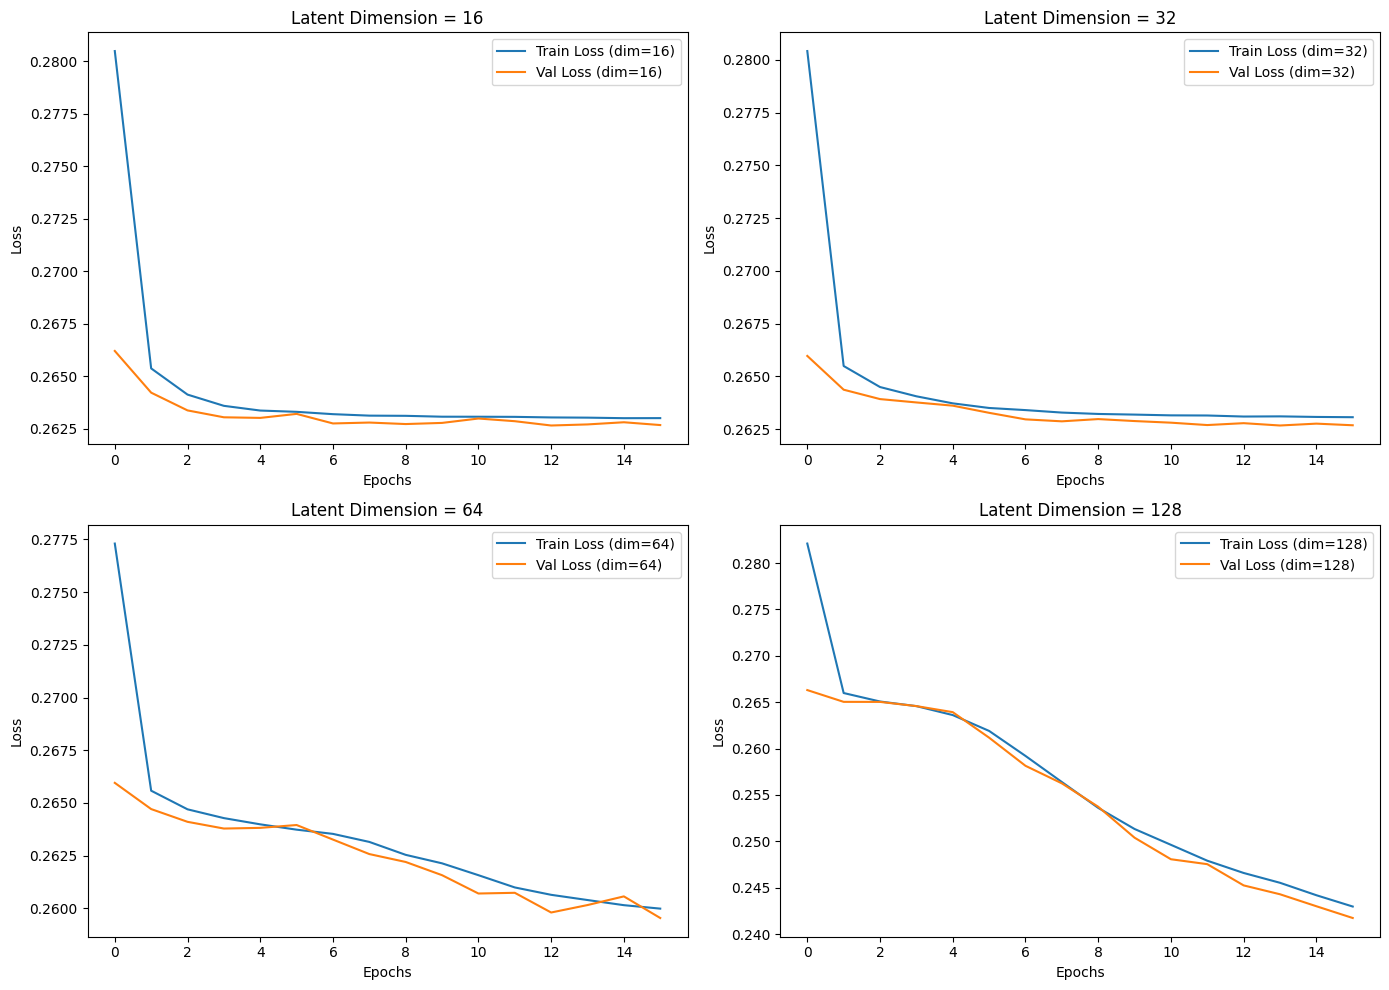

"# Plot Training vs Validation Loss for each channel\nchannels = ['rayleigh', 'rician', 'nakagami']\nfig, axes = plt.subplots(3, 1, figsize=(14, 18))  # 3 rows for 3 channels\n\nfor j, channel in enumerate(channels):\n    axes[j].set_title(f'Training vs Validation Loss for {channel.capitalize()} Channel')\n    for latent_dim in latent_dims:\n        axes[j].plot(results[channel][latent_dim]['train_loss'], label=f'Train Loss (dim={latent_dim})')\n        axes[j].plot(results[channel][latent_dim]['val_loss'], label=f'Val Loss (dim={latent_dim})', linestyle='--')\n    axes[j].set_xlabel('Epochs')\n    axes[j].set_ylabel('Loss')\n    axes[j].legend()\n\nplt.tight_layout()\nplt.show()\n"

In [ ]:
# Plot Training vs Validation Loss for each latent dimension in subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2x2 grid for 4 latent dimensions
axes = axes.flatten()  # Flatten the 2x2 array to easily iterate

for i, latent_dim in enumerate(latent_dims):
    axes[i].plot(results[latent_dim]['loss'], label=f'Train Loss (dim={latent_dim})')
    axes[i].plot(results[latent_dim]['val_loss'], label=f'Val Loss (dim={latent_dim})')
    axes[i].set_title(f'Latent Dimension = {latent_dim}')
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel('Loss')
    axes[i].legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

'''# Plot Training vs Validation Loss for each channel
channels = ['rayleigh', 'rician', 'nakagami']
fig, axes = plt.subplots(3, 1, figsize=(14, 18))  # 3 rows for 3 channels

for j, channel in enumerate(channels):
    axes[j].set_title(f'Training vs Validation Loss for {channel.capitalize()} Channel')
    for latent_dim in latent_dims:
        axes[j].plot(results[channel][latent_dim]['train_loss'], label=f'Train Loss (dim={latent_dim})')
        axes[j].plot(results[channel][latent_dim]['val_loss'], label=f'Val Loss (dim={latent_dim})', linestyle='--')
    axes[j].set_xlabel('Epochs')
    axes[j].set_ylabel('Loss')
    axes[j].legend()

plt.tight_layout()
plt.show()
'''

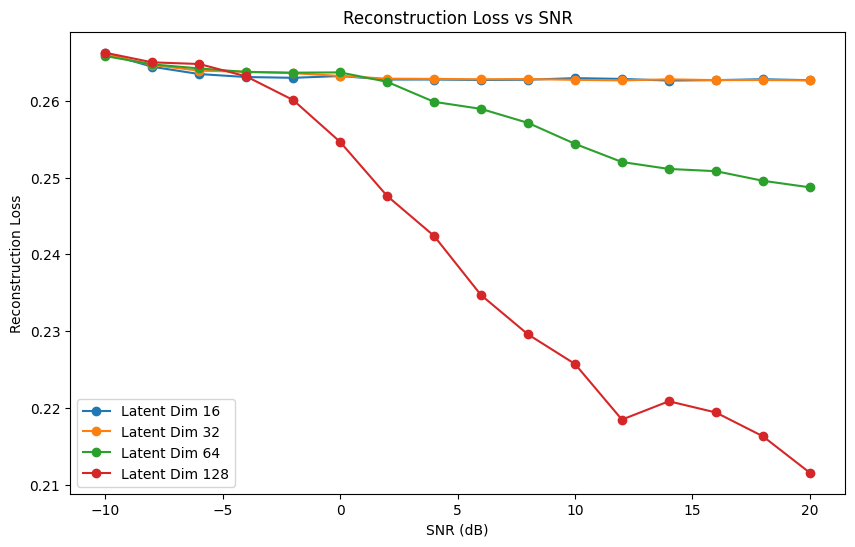

"\n# Plot Reconstruction Loss vs SNR for each channel\nfig, axes = plt.subplots(3, 1, figsize=(10, 18))  # 3 rows for 3 channels\n\nfor j, channel in enumerate(channels):\n    axes[j].set_title(f'Reconstruction Loss vs SNR for {channel.capitalize()} Channel')\n    for latent_dim in latent_dims:\n        snr_losses = [np.mean(results[channel][latent_dim]['snr_losses'][snr_db]) for snr_db in snr_values]\n        axes[j].plot(snr_values, snr_losses, marker='o', linestyle='-', label=f'Latent Dim {latent_dim}')\n    axes[j].set_xlabel('SNR (dB)')\n    axes[j].set_ylabel('Reconstruction Loss')\n    axes[j].legend()\n\nplt.tight_layout()\nplt.show()\n"

In [ ]:
# Plot Reconstruction Loss vs SNR for each latent dimension in the same plot
plt.figure(figsize=(10, 6))
for latent_dim in latent_dims:
    plt.plot(snr_values, results[latent_dim]['snr_losses'], marker='o', linestyle='-', label=f'Latent Dim {latent_dim}')

plt.title('Reconstruction Loss vs SNR')
plt.xlabel('SNR (dB)')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.show()

'''
# Plot Reconstruction Loss vs SNR for each channel
fig, axes = plt.subplots(3, 1, figsize=(10, 18))  # 3 rows for 3 channels

for j, channel in enumerate(channels):
    axes[j].set_title(f'Reconstruction Loss vs SNR for {channel.capitalize()} Channel')
    for latent_dim in latent_dims:
        snr_losses = [np.mean(results[channel][latent_dim]['snr_losses'][snr_db]) for snr_db in snr_values]
        axes[j].plot(snr_values, snr_losses, marker='o', linestyle='-', label=f'Latent Dim {latent_dim}')
    axes[j].set_xlabel('SNR (dB)')
    axes[j].set_ylabel('Reconstruction Loss')
    axes[j].legend()

plt.tight_layout()
plt.show()
'''